In [1]:
from __future__ import print_function, division

import requests
import pandas as pd
import numpy as np 
from bs4 import BeautifulSoup
import re 
from dateutil.parser import parse
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pickle

%matplotlib inline

/Users/liyuqiao/anaconda/envs/py3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
with open('../../Data/movies.pickle', 'rb') as f:
    df = pickle.load(f)

In [6]:
df.shape

(458, 11)

In [4]:
df.Actors = df.Actors.apply(lambda x: ', '.join(x))

In [5]:
df['Directors'] = df['Directors'].astype('str')

In [7]:
# for i in df['Directors']:
#     print(type(i))

In [6]:
def theathers_to_int(i):
    if type(i) != int:
        return int(i.replace(',',''))
    else: 
        return i 
df['Wildest Release'] = df['Wildest Release'].apply(theathers_to_int) 

In [7]:
def check_lst(x):
    if type(x) == list:
        x = ', '.join(x)
    else: 
        x = x
    return x 
df['Directors'] = df['Directors'].apply(check_lst)

In [8]:
df = df.replace('N/A', np.NaN)
df = df.replace(['N/A'], np.NaN)
df = df.replace(['N/a'], np.NaN)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458 entries, 0 to 207
Data columns (total 11 columns):
Movie Title                  458 non-null object
Genre                        458 non-null object
Release Date                 458 non-null datetime64[ns]
Runtime (mins)               455 non-null float64
Wildest Release              458 non-null int64
Rating                       458 non-null object
Directors                    397 non-null object
Actors                       398 non-null object
Production Budget ($)        366 non-null float64
Opening Weekend Gross ($)    458 non-null int64
Domestic Total Gross ($)     455 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 42.9+ KB


In [10]:
# drop movies released before 2007 
df = df[df['Release Date'].dt.year >= 2007]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 446 entries, 0 to 207
Data columns (total 11 columns):
Movie Title                  446 non-null object
Genre                        446 non-null object
Release Date                 446 non-null datetime64[ns]
Runtime (mins)               443 non-null float64
Wildest Release              446 non-null int64
Rating                       446 non-null object
Directors                    385 non-null object
Actors                       386 non-null object
Production Budget ($)        354 non-null float64
Opening Weekend Gross ($)    446 non-null int64
Domestic Total Gross ($)     443 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 41.8+ KB


In [12]:
# Check null values 
df[df.isnull().any(axis=1)].head(2)

,Movie Title,Genre,Release Date,Runtime (mins),Wildest Release,Rating,Directors,Actors,Production Budget ($),Opening Weekend Gross ($),Domestic Total Gross ($)
33,Despicable Me 3,3D,2017-06-30,90.0,4529,PG,Kyle BaldaPierre CoffinEric Guillon,Animation,80000000.0,72434025,NaN
78,Hubble 3D,3D,2010-03-19,43.0,39,G,"['Toni', 'Myers']","Leonardo, Di, Caprio",NaN,413477,51871619.0


In [14]:
# fill in the null values for Domestic Total Gross with mean 
df = df.fillna({"Domestic Total Gross ($)": df["Domestic Total Gross ($)"].mean()})

In [15]:
# fill in the null values for Domestic Total Gross with median
df = df.fillna({"Production Budget ($)": df["Production Budget ($)"].median()})

In [16]:
%%capture
# find the mode for 'Runtime' 
df['Runtime (mins)'].value_counts()

In [17]:
df = df.fillna({'Runtime (mins)': float(95)})

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 446 entries, 0 to 207
Data columns (total 11 columns):
Movie Title                  446 non-null object
Genre                        446 non-null object
Release Date                 446 non-null datetime64[ns]
Runtime (mins)               446 non-null float64
Wildest Release              446 non-null int64
Rating                       446 non-null object
Directors                    385 non-null object
Actors                       386 non-null object
Production Budget ($)        446 non-null float64
Opening Weekend Gross ($)    446 non-null int64
Domestic Total Gross ($)     446 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 41.8+ KB


In [19]:
df.describe()

,Runtime (mins),Wildest Release,Production Budget ($),Opening Weekend Gross ($),Domestic Total Gross ($)
count,446.000000,446.000000,4.460000e+02,4.460000e+02,4.460000e+02
mean,108.600897,2887.630045,1.088626e+08,3.672190e+07,1.162578e+08
std,18.803117,1373.764273,5.879207e+07,4.199515e+07,1.375952e+08
min,40.000000,0.000000,1.000000e+06,5.950000e+02,1.181000e+03
25%,95.000000,2658.000000,6.675000e+07,9.122624e+06,2.516197e+07
50%,106.000000,3374.000000,1.040000e+08,2.162928e+07,6.751863e+07
75%,120.000000,3845.750000,1.500000e+08,5.315917e+07,1.647405e+08
max,169.000000,4529.000000,2.600000e+08,2.479667e+08,9.366622e+08


In [20]:
df = df.drop_duplicates(subset='Movie Title',keep='first')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391 entries, 0 to 207
Data columns (total 11 columns):
Movie Title                  391 non-null object
Genre                        391 non-null object
Release Date                 391 non-null datetime64[ns]
Runtime (mins)               391 non-null float64
Wildest Release              391 non-null int64
Rating                       391 non-null object
Directors                    333 non-null object
Actors                       340 non-null object
Production Budget ($)        391 non-null float64
Opening Weekend Gross ($)    391 non-null int64
Domestic Total Gross ($)     391 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 36.7+ KB


In [22]:
df['Release Year'] = df['Release Date'].apply(lambda x: x.year)

In [24]:
# inflation = pd.read_csv('../../Data/inflation_index.txt',sep='\t')
# inflation.columns = ['year','inflation_index']

In [25]:
# inflation

In [26]:
df['Release Year'] = df['Release Year'].astype('str')

In [31]:
def year_inflation(year):
    if year == '2007': 
        return 0.843
    elif year == '2008': 
        return 0.875
    elif year == '2009':
        return 0.872
    elif year == '2010':
        return 0.886
    elif year == '2011': 
        return 0.914
    elif year == '2012': 
        return 0.933
    elif year == '2013':
        return 0.947
    elif year == '2014': 
        return 0.962
    elif year == '2015': 
        return 0.963
    elif year == '2016': 
        return 0.976
    else:
        return 1
df['Release Year'] = df['Release Year'].apply(year_inflation)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391 entries, 0 to 207
Data columns (total 12 columns):
Movie Title                  391 non-null object
Genre                        391 non-null object
Release Date                 391 non-null datetime64[ns]
Runtime (mins)               391 non-null float64
Wildest Release              391 non-null int64
Rating                       391 non-null object
Directors                    333 non-null object
Actors                       340 non-null object
Production Budget ($)        391 non-null float64
Opening Weekend Gross ($)    391 non-null int64
Domestic Total Gross ($)     391 non-null float64
Release Year                 391 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(3), object(5)
memory usage: 39.7+ KB


In [33]:
df['Production Budget ($)'] = (df['Production Budget ($)'] 
                                      / df['Release Year'])

In [34]:
df['Opening Weekend Gross ($)'] = (df['Opening Weekend Gross ($)'] 
                                      / df['Release Year'])

In [35]:
df['Domestic Total Gross ($)'] = (df['Domestic Total Gross ($)'] 
                                      / df['Release Year'])

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391 entries, 0 to 207
Data columns (total 12 columns):
Movie Title                  391 non-null object
Genre                        391 non-null object
Release Date                 391 non-null datetime64[ns]
Runtime (mins)               391 non-null float64
Wildest Release              391 non-null int64
Rating                       391 non-null object
Directors                    333 non-null object
Actors                       340 non-null object
Production Budget ($)        391 non-null float64
Opening Weekend Gross ($)    391 non-null float64
Domestic Total Gross ($)     391 non-null float64
Release Year                 391 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(2), object(5)
memory usage: 39.7+ KB


In [38]:
df['Release Date'] = df['Release Date'].apply(lambda x: x.month)

In [39]:
df.rename(columns={'Release Date':'Release Month'}, inplace=True)

In [40]:
df.rename(columns={'Domestic Total Gross ($)':'DomesticTotalGross'}, inplace=True)

In [41]:
avg_dtg = df.groupby(['Release Month']).DomesticTotalGross.mean()

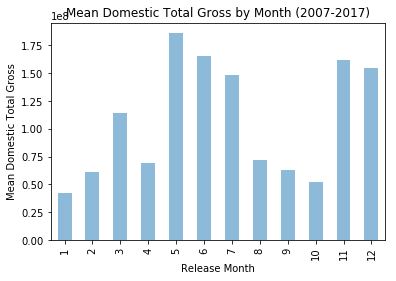

In [695]:
avg_dtg.plot(kind='bar', alpha=0.5)
plt.ylabel('Mean Domestic Total Gross')
plt.xlabel('Release Month')
plt.title('Mean Domestic Total Gross by Month (2007-2017)')

In [696]:
# def release_month_buckets(month):
#     if month in range(3,6):
#         return 'Spring'
#     elif month in range(6,9):
#         return 'Summer'
#     elif month in range(9,12):
#         return 'Fall'
#     else:
#         return 'Winter'
# movies_df['Release Month'] = movies_df['Release Month'].apply(release_month_buckets)

In [42]:
df = pd.get_dummies(df
                           , columns=['Release Month']
                           , prefix=["Release Month"]
                           , drop_first=True)

In [43]:
def ratings_buckets(rating):
    if rating == 'PG-13' or rating == 'PG':
        return 'PG/PG-13'
    elif rating == 'Unknown':
        return 'Unrated'
    else: 
        return rating 
df['Rating'] = df['Rating'].apply(ratings_buckets)

In [44]:
df = pd.get_dummies(df, columns=['Rating'], prefix=["MPAA"], drop_first=True)

In [45]:
df = pd.get_dummies(df, columns=['Genre'], prefix=["Genre"], drop_first=True)

In [46]:
budget_mean = df['Production Budget ($)'].mean()

In [47]:
df.drop('Release Year', axis=1, inplace = True)

In [48]:
df

,Movie Title,Runtime (mins),Wildest Release,Directors,Actors,Production Budget ($),Opening Weekend Gross ($),DomesticTotalGross,Release Month_2,Release Month_3,...,Release Month_7,Release Month_8,Release Month_9,Release Month_10,Release Month_11,Release Month_12,MPAA_PG/PG-13,MPAA_R,MPAA_Unrated,Genre_3D
0,Star Wars: The Force Awakens,136.0,4134,J.J. Abrams,"John, Boyega, Daisy, Ridley, Adam, Driver, Osc...",245000000.0,247966675.0,936662225.0,0,0,...,0,0,0,0,0,1,1,0,0,1
1,Avatar,160.0,3452,James Cameron,"Sam, Worthington, Zoe, Saldana, Sigourney, Wea...",237000000.0,77025481.0,749766139.0,0,0,...,0,0,0,0,0,1,1,0,0,1
2,Jurassic World,124.0,4274,Colin Trevorrow,"Nick, Robinson, Omar, Sy, Chris, Pratt, Bryce,...",150000000.0,208806270.0,652270625.0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,Marvel's The Avengers,142.0,4349,Joss Whedon,"Robert, Downey,, Jr., Chris, Hemsworth, Chris,...",220000000.0,207438708.0,623357910.0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,Rogue One: A Star Wars Story,133.0,4157,Gareth Edwards,"Felicity, Jones, Mads, Mikkelsen, Ben, Mendels...",200000000.0,155081681.0,532177324.0,0,0,...,0,0,0,0,0,1,1,0,0,1
5,Beauty and the Beast,129.0,4210,Bill Condon,"Emma, Watson, Luke, Evans, Emma, Thompson, Kev...",160000000.0,174750616.0,504014165.0,0,1,...,0,0,0,0,0,0,1,0,0,1
6,Finding Dory,103.0,4305,Angus MacLane Andrew Stanton,Animation,200000000.0,135060273.0,486295561.0,0,0,...,0,0,0,0,0,0,1,0,0,1
7,Avengers: Age of Ultron,141.0,4276,Joss Whedon,"Robert, Downey,, Jr., Chris, Hemsworth, Mark, ...",250000000.0,191271109.0,459005868.0,0,0,...,0,0,0,0,0,0,1,0,0,1
8,Toy Story 3,103.0,4028,Lee Unkrich,Animation,200000000.0,110307189.0,415004880.0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,Wonder Woman,141.0,4165,Patty Jenkins,"Gal, Gadot, Chris, Pine, Connie, Nielsen, Robi...",149000000.0,103251471.0,412038809.0,0,0,...,0,0,0,0,0,0,1,0,0,1


(array([  37.,   45.,   40.,  121.,   31.,   38.,   36.,   21.,   10.,   12.]),
 array([  1.00000000e+06,   2.69000000e+07,   5.28000000e+07,
          7.87000000e+07,   1.04600000e+08,   1.30500000e+08,
          1.56400000e+08,   1.82300000e+08,   2.08200000e+08,
          2.34100000e+08,   2.60000000e+08]),
 <a list of 10 Patch objects>)

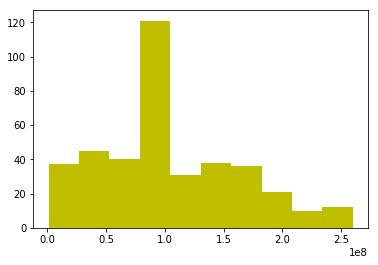

In [49]:
plt.hist(df['Production Budget ($)'], color = 'y')

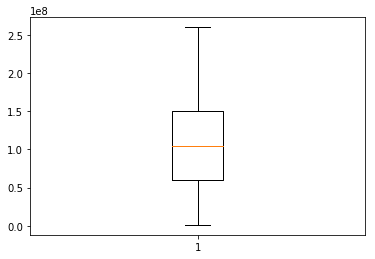

In [50]:
B = plt.boxplot(df['Production Budget ($)'])

In [51]:
[item.get_ydata() for item in B['whiskers']]
interquartile =[item.get_ydata()[0] for item in B['whiskers']]

In [52]:
twenty_five_percentile = interquartile[0]
seventy_five_percentile = interquartile[1]

In [53]:
def prod_budget_buckets(budget):
    if budget < twenty_five_percentile:
        return 'Small'
    elif budget < seventy_five_percentile:
        return 'Medium'
    else: 
        return 'Large'
df['Production Budget ($)'] = df['Production Budget ($)'].apply(prod_budget_buckets)

In [54]:
df = pd.get_dummies(df
                            , columns=['Production Budget ($)']
                            , prefix = 'Prod_Budget', drop_first=True)

(array([ 67.,   3.,   4.,   5.,   6.,  28.,  64.,  71.,  98.,  45.]),
 array([    0. ,   452.9,   905.8,  1358.7,  1811.6,  2264.5,  2717.4,
         3170.3,  3623.2,  4076.1,  4529. ]),
 <a list of 10 Patch objects>)

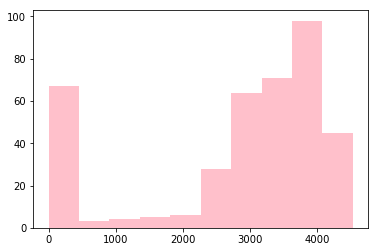

In [55]:
plt.hist(df['Wildest Release'],color='pink')

In [56]:
def wild_release_buckets(theaters):
    if theaters <= 599:
        return 'Limited'
    elif theaters <= 3000:
        return 'Wild'
    else: 
        return 'Huge'
df['Wildest Release'] = df['Wildest Release'].apply(wild_release_buckets)

In [57]:
df = pd.get_dummies(df, columns=['Wildest Release'], prefix = 'Release', drop_first=True)

In [360]:
# fig, axes = plt.subplots(2,2, figsize=(15,5))
# for (rating, group), ax in zip(movies.groupby(['Rating']), axes.flatten()):
#     group.plot(x='ReleaseDate', y='DomesticTotalGross', ax=ax, title=rating, style='r--')

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391 entries, 0 to 207
Data columns (total 25 columns):
Movie Title                  391 non-null object
Runtime (mins)               391 non-null float64
Directors                    333 non-null object
Actors                       340 non-null object
Opening Weekend Gross ($)    391 non-null float64
DomesticTotalGross           391 non-null float64
Release Month_2              391 non-null uint8
Release Month_3              391 non-null uint8
Release Month_4              391 non-null uint8
Release Month_5              391 non-null uint8
Release Month_6              391 non-null uint8
Release Month_7              391 non-null uint8
Release Month_8              391 non-null uint8
Release Month_9              391 non-null uint8
Release Month_10             391 non-null uint8
Release Month_11             391 non-null uint8
Release Month_12             391 non-null uint8
MPAA_PG/PG-13                391 non-null uint8
MPAA_R                

#### Extract info on Oscar winners For Best Actor/Actress/Director
http://www.nndb.com

In [60]:
# Depending on director's average domestic total gross per movie, 
# bag directors into 
df.groupby(['Directors']).DomesticTotalGross.mean().sort_values(ascending=False)[:10]

Directors
James Cameron                   7.497661e+08
Colin Trevorrow                 6.522706e+08
Joss Whedon                     5.411819e+08
Bill Condon                     5.040142e+08
Angus MacLane Andrew Stanton    4.862956e+08
J.J. Abrams                     4.308150e+08
Lee Unkrich                     4.150049e+08
Patty Jenkins                   4.120388e+08
Shane Black                     4.090140e+08
Gary Ross                       4.080107e+08
Name: DomesticTotalGross, dtype: float64

In [61]:
def director_gross_ranking(director):
    if (df.groupby(['Directors'])
        .DomesticTotalGross.mean()
        .sort_values(ascending=False)[director]) > 400000000:
        return 'Above_40'
    elif (df.groupby(['Directors'])
        .DomesticTotalGross.mean()
        .sort_values(ascending=False)[director]) > 200000000:
        return 'Above_20'
    elif (df.groupby(['Directors'])
        .DomesticTotalGross.mean()
        .sort_values(ascending=False)[director]) > 99999999:
        return 'Above_10'
    elif (df.groupby(['Directors'])
        .DomesticTotalGross.mean()
        .sort_values(ascending=False)[director]) > 9999999:
        return 'Above_1'
    else: 
        return 'Below_1'

In [62]:
df['Directors'] = df['Directors'].astype('str')

In [365]:
# for i in movies_df['Directors']:
#     print(type(i))

In [63]:
df['Directors'] = df['Directors'].apply(director_gross_ranking)

In [64]:
df = pd.get_dummies(df
                           , columns=['Directors']
                           , prefix = 'Director'
                           , drop_first=True)

In [368]:
# valuable_directors_df = pd.read_csv('valuable_directors.txt', sep=",")
# valuable_directors_df.columns = ['director']

In [65]:
valuable_actors_df = pd.read_csv('valuable_actors.txt', sep=",")
valuable_actors_df.columns = ['index','actor/actress'
                     ,'total gross','movies'
                     ,'avg gross','#1 picture','gross']

In [66]:
valuable_actors_df = valuable_actors_df['actor/actress']

In [67]:
valuable_actors_df.head()

0         Harrison Ford
1             Tom Hanks
2        Morgan Freeman
3    Robert Downey, Jr.
4          Eddie Murphy
Name: actor/actress, dtype: object

In [68]:
def check_actors_match(actors):
    """Returns a counter that helps transform star power
    to measurable values. Any actor/actress that are within 
    the top 100 highest total lifetime gross list will be 
    given a score of 2, else 1 (0 for NaN values).
     """
    count = 1
    for name in valuable_actors_df:
        if name in actors:
            count += 1  
    return count 
df['Actors'] = df['Actors'].astype('str')

In [69]:
df['Actors'] = df['Actors'].apply(lambda x : x.replace(', ',' '))

In [70]:
df['Actors'] = df['Actors'].apply(check_actors_match)

In [71]:
df.Actors.value_counts()

1    269
2     59
3     34
4     13
6      7
7      4
5      4
8      1
Name: Actors, dtype: int64

In [72]:
df = pd.get_dummies(df, columns=['Actors'], prefix = 'Actors Rank', drop_first=True)

In [77]:
df['Opening Weekend Gross ($)']=[x/1000000 for x in df['Opening Weekend Gross ($)']]

In [79]:
df['DomesticTotalGross']=[x/1000000 for x in df['DomesticTotalGross']]

In [80]:
df

,Movie Title,Runtime (mins),Opening Weekend Gross ($),DomesticTotalGross,Release Month_2,Release Month_3,Release Month_4,Release Month_5,Release Month_6,Release Month_7,...,Director_Above_20,Director_Above_40,Director_Below_1,Actors Rank_2,Actors Rank_3,Actors Rank_4,Actors Rank_5,Actors Rank_6,Actors Rank_7,Actors Rank_8
0,Star Wars: The Force Awakens,136.0,247.966675,936.662225,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,Avatar,160.0,77.025481,749.766139,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
2,Jurassic World,124.0,208.806270,652.270625,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,0,0
3,Marvel's The Avengers,142.0,207.438708,623.357910,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
4,Rogue One: A Star Wars Story,133.0,155.081681,532.177324,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
5,Beauty and the Beast,129.0,174.750616,504.014165,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
6,Finding Dory,103.0,135.060273,486.295561,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
7,Avengers: Age of Ultron,141.0,191.271109,459.005868,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
8,Toy Story 3,103.0,110.307189,415.004880,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
9,Wonder Woman,141.0,103.251471,412.038809,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [81]:
with open('../../Data/movies_clean.pickle', 'wb') as handle: 
    pickle.dump(df, handle, pickle.HIGHEST_PROTOCOL)

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391 entries, 0 to 207
Data columns (total 34 columns):
Movie Title                  391 non-null object
Runtime (mins)               391 non-null float64
Opening Weekend Gross ($)    391 non-null float64
DomesticTotalGross           391 non-null float64
Release Month_2              391 non-null uint8
Release Month_3              391 non-null uint8
Release Month_4              391 non-null uint8
Release Month_5              391 non-null uint8
Release Month_6              391 non-null uint8
Release Month_7              391 non-null uint8
Release Month_8              391 non-null uint8
Release Month_9              391 non-null uint8
Release Month_10             391 non-null uint8
Release Month_11             391 non-null uint8
Release Month_12             391 non-null uint8
MPAA_PG/PG-13                391 non-null uint8
MPAA_R                       391 non-null uint8
MPAA_Unrated                 391 non-null uint8
Genre_3D                